In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Llama/Llama_After_RLHF.csv')

In [3]:
df

,Question,Gen_Answer,Gen_Grade,Gen_Reward,RL_Answer,RL_Grade,RL_Reward
0,You participated in a competition and won the ...,"Dear Mrs. Ryan, I am writing to you in reply ...",NaN,NaN,I am very happy to hear that I have won first ...,NaN,NaN
1,Your class is going to make a short video on d...,1. Introduction 2. English lesson 3. Maths les...,NaN,NaN,The lesson that should have been filmer is the...,NaN,NaN
2,"Write a composition giving your opinions on ""S...",Shopping is a very popular activity for peopl...,NaN,NaN,Shopping can be enjoyble but it can also be a ...,NaN,NaN
3,Last month you helped organizing a pop concert...,"Dear Kim, I'm writing to tell you about my ex...",NaN,NaN,I am writing to you to tell you about my exper...,NaN,NaN
4,Your English class is going to spend three day...,"Dear Mr Robertson, I am writing to you to tha...",NaN,NaN,I am writing to you to give you some suggestio...,NaN,NaN
5,"Write a composition giving your opinions on ""F...",I think that famous people should have their p...,NaN,NaN,I think that famous people should have their p...,NaN,NaN
6,"write an article on, ""The Home of the Future: ...",The home of the future The home is the pla...,NaN,NaN,The home of future is a very interesting topic...,NaN,NaN
7,Write a story for the college magazine beginni...,"It was Dangerous, But I Knew I Had to Do It I...",NaN,NaN,It was a dangerous but exciting experience. I ...,NaN,NaN
8,You are helping to organise an international s...,"Dear Mrs Smith, I am writing in reply to your...",NaN,NaN,I am writing in reply to the letter you sent m...,NaN,NaN
9,Write a report for the group leader of a group...,The building I would like to recommend is the ...,NaN,NaN,I think that the building that I would recomme...,NaN,NaN


**REWARD**

In [4]:
!pip install transformers -q
!pip install datasets==2.16.1 -q
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00


In [5]:
import numpy as np
from transformers import Pipeline


def softmax(outputs):
    maxes = np.max(outputs, axis=-1, keepdims=True)
    shifted_exp = np.exp(outputs - maxes)
    return shifted_exp / shifted_exp.sum(axis=-1, keepdims=True)


class PairClassificationPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "second_text" in kwargs:
            preprocess_kwargs["second_text"] = kwargs["second_text"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, text, second_text=None):
        return self.tokenizer(text, text_pair=second_text, return_tensors=self.framework)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        logits = model_outputs.logits[0].numpy()
        probabilities = softmax(logits)

        best_class = np.argmax(probabilities)
        label = self.model.config.id2label[best_class]
        score = probabilities[best_class].item()
        logits = logits.tolist()
        return {"label": label, "score": score, "logits": logits}




from transformers.pipelines import PIPELINE_REGISTRY
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification

PIPELINE_REGISTRY.register_pipeline(
    "pair-classification",
    pipeline_class=PairClassificationPipeline,
    pt_model=AutoModelForSequenceClassification,
    tf_model=TFAutoModelForSequenceClassification,
)



from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Specify the model and tokenizer names
model_name = "RajuEEE/RewardModel_RobertaBase"
tokenizer_name = "RajuEEE/RewardModel_RobertaBase"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Instantiate the PairClassificationPipeline
qa_pipe = PairClassificationPipeline(model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [6]:
out=qa_pipe(df.iloc[0]['Question'],second_text=df.iloc[0]['Gen_Answer'] )
df.at[0, 'Gen_Grade']=out['label']
df.at[0, 'Gen_Reward']=out['logits'][1]

In [7]:
df

,Question,Gen_Answer,Gen_Grade,Gen_Reward,RL_Answer,RL_Grade,RL_Reward
0,You participated in a competition and won the ...,"Dear Mrs. Ryan, I am writing to you in reply ...",Good,2.608215,I am very happy to hear that I have won first ...,NaN,NaN
1,Your class is going to make a short video on d...,1. Introduction 2. English lesson 3. Maths les...,NaN,NaN,The lesson that should have been filmer is the...,NaN,NaN
2,"Write a composition giving your opinions on ""S...",Shopping is a very popular activity for peopl...,NaN,NaN,Shopping can be enjoyble but it can also be a ...,NaN,NaN
3,Last month you helped organizing a pop concert...,"Dear Kim, I'm writing to tell you about my ex...",NaN,NaN,I am writing to you to tell you about my exper...,NaN,NaN
4,Your English class is going to spend three day...,"Dear Mr Robertson, I am writing to you to tha...",NaN,NaN,I am writing to you to give you some suggestio...,NaN,NaN
5,"Write a composition giving your opinions on ""F...",I think that famous people should have their p...,NaN,NaN,I think that famous people should have their p...,NaN,NaN
6,"write an article on, ""The Home of the Future: ...",The home of the future The home is the pla...,NaN,NaN,The home of future is a very interesting topic...,NaN,NaN
7,Write a story for the college magazine beginni...,"It was Dangerous, But I Knew I Had to Do It I...",NaN,NaN,It was a dangerous but exciting experience. I ...,NaN,NaN
8,You are helping to organise an international s...,"Dear Mrs Smith, I am writing in reply to your...",NaN,NaN,I am writing in reply to the letter you sent m...,NaN,NaN
9,Write a report for the group leader of a group...,The building I would like to recommend is the ...,NaN,NaN,I think that the building that I would recomme...,NaN,NaN


In [8]:
out['logits'][1]

2.6082146167755127

In [9]:
for i in range(len(df)):
  print(i)
  text1=df.iloc[i]['Question']
  text2=df.iloc[i]['Gen_Answer']
  text3=df.iloc[i]['Gen_Answer']

  out=qa_pipe(df.iloc[i]['Question'],second_text=df.iloc[i]['Gen_Answer'] )
  df.at[i, 'Gen_Grade']=out['label']
  df.at[i, 'Gen_Reward']=out['logits'][1]

  out=qa_pipe(df.iloc[i]['Question'],second_text=df.iloc[i]['RL_Answer'] )
  df.at[i, 'RL_Grade']=out['label']
  df.at[i, 'RL_Reward']=out['logits'][1]




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


# Performance on Training Data

In [10]:
df_train=df[0:26]

Statistical measures for RL_Reward(Training Data):
Mean: 2.4110154463694644
Variance: 0.2165255627898071
Median: 2.610270619392395


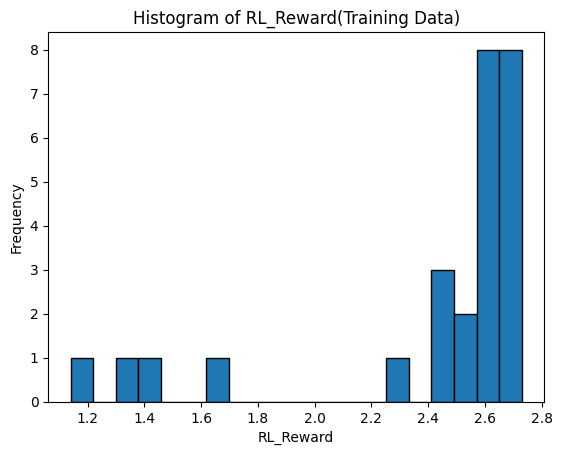

Number of 'Good' in RL_Answer column: 26
Percentage of 'Good' in RL_Answer column: 100.0


In [18]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Example DataFrame creation:
# df = pd.DataFrame({'RL_Reward': [10, 15, 20, 25, 30],
#                    'RL_Answer': ['Good', 'Bad', 'Good', 'Bad', 'Good']})

# Display various statistical measures for RL_Reward
print("Statistical measures for RL_Reward(Training Data):")
print("Mean:", df_train['RL_Reward'].mean())
print("Variance:", df_train['RL_Reward'].var())
print("Median:", df_train['RL_Reward'].median())

# Draw histogram for RL_Reward
plt.hist(df_train['RL_Reward'], bins=20, edgecolor='black')
plt.title('Histogram of RL_Reward(Training Data)')
plt.xlabel('RL_Reward')
plt.ylabel('Frequency')
plt.show()

# Find the number of "Good" in RL_Answer column
good_count = df_train['RL_Grade'].value_counts().get('Good', 0)
print("Number of 'Good' in RL_Answer column:", good_count)

total_rows = len(df_train)
percentage_good = (df_train['RL_Grade'].value_counts().get('Good', 0) / total_rows) * 100
print("Percentage of 'Good' in RL_Answer column:", percentage_good)


Statistical measures for Gen_Reward(Training Data):
Mean: 1.8780085829874644
Variance: 0.9784326861771306
Median: 2.4937973022460938


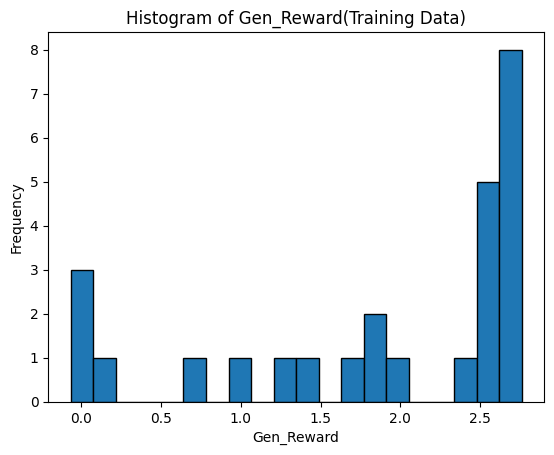

Number of 'Good' in Gen_Grade column: 24
Percentage of 'Good' in Gen_Grade column: 92.3076923076923


In [19]:
# Display various statistical measures for Gen_Reward
print("Statistical measures for Gen_Reward(Training Data):")
print("Mean:", df_train['Gen_Reward'].mean())
print("Variance:", df_train['Gen_Reward'].var())
print("Median:", df_train['Gen_Reward'].median())

# Draw histogram for RL_Reward
plt.hist(df_train['Gen_Reward'], bins=20, edgecolor='black')
plt.title('Histogram of Gen_Reward(Training Data)')
plt.xlabel('Gen_Reward')
plt.ylabel('Frequency')
plt.show()

# Find the number of "Good" in Gen_Grade column
good_count = df_train['Gen_Grade'].value_counts().get('Good', 0)
print("Number of 'Good' in Gen_Grade column:", good_count)

total_rows = len(df_train)
percentage_good = (df_train['Gen_Grade'].value_counts().get('Good', 0) / total_rows) * 100
print("Percentage of 'Good' in Gen_Grade column:", percentage_good)

In [20]:
print("Total Rows for Training Data:", len(df_train))
improvement=len(df_train[df_train['RL_Reward'] > df_train['Gen_Reward']])
print("RL Improves Reward for:", improvement,"Rows")
print("Percentage of Cases RL Improves Reward:",(improvement/len(df_train))*100,"%");

Total Rows for Training Data: 26
RL Improves Reward for: 16 Rows
Percentage of Cases RL Improves Reward: 61.53846153846154 %


# Performance on Evaluation Data

In [14]:
df_eval=df[26:]

Statistical measures for RL_Reward(Evaluation Data):
Mean: 2.0353892420729003
Variance: 1.3412068318211492
Median: 2.539010763168335


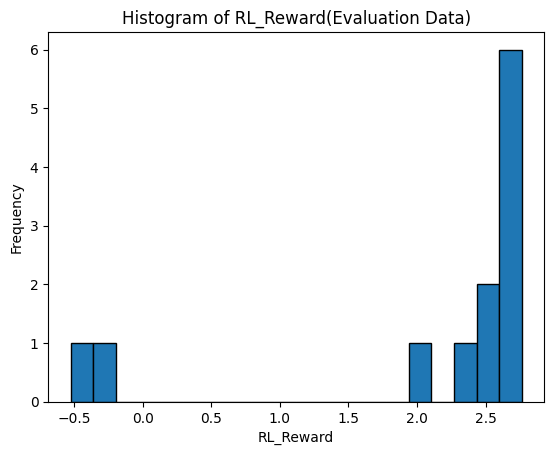

Number of 'Good' in RL_Answer column: 10
Percentage of 'Good' in RL_Answer column: 83.33333333333334


In [21]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Example DataFrame creation:
# df = pd.DataFrame({'RL_Reward': [10, 15, 20, 25, 30],
#                    'RL_Answer': ['Good', 'Bad', 'Good', 'Bad', 'Good']})

# Display various statistical measures for RL_Reward
print("Statistical measures for RL_Reward(Evaluation Data):")
print("Mean:", df_eval['RL_Reward'].mean())
print("Variance:", df_eval['RL_Reward'].var())
print("Median:", df_eval['RL_Reward'].median())

# Draw histogram for RL_Reward
plt.hist(df_eval['RL_Reward'], bins=20, edgecolor='black')
plt.title('Histogram of RL_Reward(Evaluation Data)')
plt.xlabel('RL_Reward')
plt.ylabel('Frequency')
plt.show()

# Find the number of "Good" in RL_Answer column
good_count = df_eval['RL_Grade'].value_counts().get('Good', 0)
print("Number of 'Good' in RL_Answer column:", good_count)

total_rows = len(df_eval)
percentage_good = (df_eval['RL_Grade'].value_counts().get('Good', 0) / total_rows) * 100
print("Percentage of 'Good' in RL_Answer column:", percentage_good)


Statistical measures for Gen_Reward(Evaluation Data):
Mean: 1.6146558746695518
Variance: 2.3340162533001765
Median: 2.5857075452804565


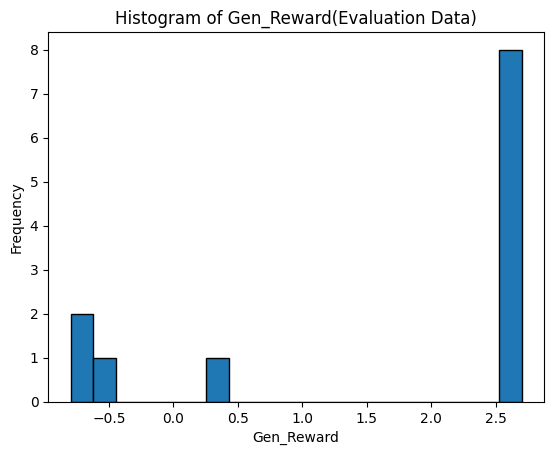

Number of 'Good' in Gen_Grade column: 9
Percentage of 'Good' in Gen_Grade column: 75.0


In [23]:
# Display various statistical measures for Gen_Reward
print("Statistical measures for Gen_Reward(Evaluation Data):")
print("Mean:", df_eval['Gen_Reward'].mean())
print("Variance:", df_eval['Gen_Reward'].var())
print("Median:", df_eval['Gen_Reward'].median())

# Draw histogram for RL_Reward
plt.hist(df_eval['Gen_Reward'], bins=20, edgecolor='black')
plt.title('Histogram of Gen_Reward(Evaluation Data)')
plt.xlabel('Gen_Reward')
plt.ylabel('Frequency')
plt.show()

# Find the number of "Good" in Gen_Grade column
good_count = df_eval['Gen_Grade'].value_counts().get('Good', 0)
print("Number of 'Good' in Gen_Grade column:", good_count)

total_rows = len(df_eval)
percentage_good = (df_eval['Gen_Grade'].value_counts().get('Good', 0) / total_rows) * 100
print("Percentage of 'Good' in Gen_Grade column:", percentage_good)

In [17]:
print("Total Rows for Training Data:", len(df_eval))
improvement=len(df_eval[df_eval['RL_Reward'] > df_eval['Gen_Reward']])
print("RL Improves Reward for:", improvement,"Rows")
print("Percentage of Cases RL Improves Reward:",(improvement/len(df_eval))*100,"%");

Total Rows for Training Data: 12
RL Improves Reward for: 6 Rows
Percentage of Cases RL Improves Reward: 50.0 %


**Visual Evaluation**

In [40]:
for i in range(0,25,10):
  display("Question:",df_train.iloc[i]["Question"])
  print("FineTunedModel:")
  display(df_train.iloc[i]['Gen_Answer'])
  print("After RLHF:");
  display(df_train.iloc[i]['RL_Answer'])
  print("\n\n")

'Question:'

'You participated in a competition and won the first prize. The Organizer had written you a letter congratulating you. Now, Write a reply letter of between 120 to 180 words.'

FineTunedModel:


"Dear Mrs. Ryan,  I am writing to you in reply to your letter. I would like to travel in July because I have to work in August. About the accommodation, I prefer to stay in tents because it is more exciting and I like adventure. As for the activities, my favourite is swimming because  it's my best sport. Finally, could you tell me how much money I need and how I can get there.   Yours sincerely"

After RLHF:


"I am very happy to hear that I have won first place in your competition. I would like to say thank you for giving me the chance to go to California. It is a dream of mine to travel to the U.S.A. and I will be able to do it this year. As for the two weeks at the camp, I can only go in July because I need to work in August. And I want to stay in log cabins because it is more comfortable than tents. Also, there are more facilities in cabiins. For the activities, swimming and surfing are my favourite sports. Swimming is my best sport and it makes me feel relaxed. Surf is also my hobby and when I surfs, it gives me a lot of fun. Finally, could you tell me what kind of clothes I should bring? I look forward to hearing from you soon. Thank you very much.  I hope you will give me this chance.   I'm looking forward  to it  Your"

'Question:'

'Write an article for an international magazine on a great scientific invention, explaining why you think it is important and saying how it has affected your own life. '

FineTunedModel:


"The infection of computers is a very important in my life, because I use it every day. I think that the inversion of the computer is very useful for me. It is useful because it helps me to do my homework, to write my essays and to  do some research. The computer has changed my  life because now I can do all my work with the  computer and I don't have to use a typewriter. In the future I hope that  the   computer will be more  advanced and that I will have a computer at home.   In conclusion I want to say that if I had to choose between a life without the use of a  personal computer or a   life with it I would choose the second one"

After RLHF:


"I think the invenion of the car is very important. It is the most important in my life because I can go anywhere I want to go. I don't have to walk or take a bus. The car can take me to the place I need to be. If I have a problem, I call my friend and he comes to my house in his car. He can' t come if he has to take the bus or walk. My car has a lot of advantages. For example, if I am tired, my car will take my tiredness away. When I go to work, it will help me go there. And when I come back from work I will be happy because my home is near my work. So I like my cars. They are very good for me. But I know that cars are bad for the environment. We should think about the future."

'Question:'

' Write a letter,of between 120 and 180 words  to the organizer,Jane Clark, on how annual international arts festival can be made better. .'

FineTunedModel:


'Dear Jane Clark  I am writing to you to give you some suggestions about the International Arts Festival. First of all, I think it was a good idea to organize an international festival, but I have to say that I was disappointed because there were not many stars. I would suggest you invite more stars next year. Secondly, the concerts were very good, especially the classical concert. However, there was only one concert and I  would like to have more. Thirdly , I went to see the plays and films. The plays were good but there  were only two plays. In my opinion, you should have  more plays next time. Finally, it would be a great idea if you could organise a jazz concert or a rock concert next  year . I hope you will consider my suggestions.   Yours sincerely'

After RLHF:


'Dear Jane Clark: I am writing to give my opinion about the annual International Arts Festival. I think it was a good idea to have an international festival, but I have some suggestions to make it better next year. First of all, I would like to say that I enjoyed the festival very much. It was very interesting to see the different cultures and arts. However, there were some things that could be improved. For example, the number of stars and artists was not enough. There were only six stars, and I was disappointed because I wanted to watch more stars. Also, it would be better if there was more music and art. In addition, if you could have more concerts and plays, that would make the event more interesting. Finally, you should have a discount for students. If you have these things, next years festival will be more successful. Thank you for your time and consideration.   Thank You  Yours Sincerely'

In [39]:
for i in range(0,11,5):
  display("Question:",df_eval.iloc[i]["Question"])
  print("FineTunedModel:")
  display(df_eval.iloc[i]['Gen_Answer'])
  print("After RLHF:");
  display(df_eval.iloc[i]['RL_Answer'])
  print("\n\n")

'Question:'

'You have been asked to write an article for your school magazine with the title: My favourite season of the year. Describe your favourite season and explain why it is so special for you. Write your article'

FineTunedModel:


"I think that the best season is summer. It is the season when the weather is warm and the sun is shining. I like to go to the beach in summer and I also like swimming in the sea. In summer I can go out with my friends and we can have a barbecue. We can also go for a walk in a park and play some games. Summer is also the time when I have my holidays. My holiday is in August and it lasts for two weeks. During my summer holida I go on a camp and do some activities. There are a lot of activities to do and you can make new friends. The best thing about summer is that I don't have to wear a coat and a scarf.  The worst thing is when it rains and is cold"

After RLHF:


"I think that my favourate season is summer. I like summer because it's the best season. In summer, I can go to the beach and swim in the sea. It'll be very nice to swimming in summer and I love swimmig. Summer is the season that I have a lot of holidays. And I go on holiday with my family. We go swmming and we go shopping. My family and me go out to eat and go home. But I don't like winter because I hate cold. Winter is a season I want to go away from home and stay in a hotel. Because I'm not like to stay at home in winter. So I hope that summer will come soon.  I wish that winter will go soon  So, summer is my favorite season  because summer has a nice weather and a long holida  My favorite sport is swmming  Because swming is very fun and it makes me healthy  And my hobby is shooping and eatin"

'Question:'

'The school where you learn English has decided to buy some videos in English. Write a report suggesting what kinds of videos the school should buy. In your report, you should also explain why students at the school will enjoy these videos. Write your report'

FineTunedModel:


'13th June, 2001  Dear Sir/Madam, I am writing to you in order to give you some advice about the videos which the  school   has   decided   to   buy . I have been asked to write a  report about it. I think that the students will be very happy with the choice of the films. The first film is "The American  President" . It is a very funny film and the actors are very good. It will help the student to understand the way of life in the U.S.A. and to learn the English language. Another film which I would like to suggest is  "Romeo and Juliet". It  is   a film about love and it is very romantic. This film will  help them to improve their vocabulary and their pronunciation.   Yours faithfully'

After RLHF:


'The school has a good idea to spend money on English videos, because it is a very good way to learn and enjoy English at home. I think the best kind of video is "English in the kitchen" because students can learn how to cook and speak English in a kitchen. It is very useful for students to know how cooking and speaking English are related. Another kind is English news, students will know what is happening in England and the world. They can also learn new words and expressions. The last kind I suggest is the English cartoon. Students can enjoy the cartoons and learn the words in it. So I hope the students enjoy and have fun with the videos and they can speak and know more English than before.  So i hope you can buy the kind that I suggested.   So you will have a lot of fun and you  will learn a  lot  of English  at your home  I am looking forward to hearing from you'

'Question:'

"You have decided to enter a short story competition in an international magazine. The competition rules say that the story must begin with the following words: It was three o'clock in the morning when the phone rang. Write your story."

FineTunedModel:


"I was lying in my bed, thinking about the next day. I had to go to work and I didn't want to. Suddenly the telephone rang and it was my boss. He told me that I  had been chosen to  work in a new department. It would be a great opportunity for me and my family. But I couldn' t believe it. My bones were shaking and  my heart was beating very fast. When I arrived at work, I saw that it wasn'  a dream.   I'm looking forward to hearing from you"

After RLHF:


"I was lying in my bed and I heard the telephone ringing. I got up and went to the kitchen to answer the call. It wasn't my mother, it was my father. He asked me if I had seen my brother. My brother was in a car accident and he was dying. We had to go to hospital. When we arrived at the hospital, my dad was crying and my mom was very sad. They told me that my little brother had died. After that, I went home and cried. Then I decided that I would never cry again. So I never cried again and now I am a very strong person.  I have a lot of friends and they are all very nice to me. And I think that is the best thing that has ever happened to my life.   I will never be sad again because I know that if my baby brother died, then I can be strong and never  cry  again"